# A real world workchain example: electronic band structure

*Import statements - make sure to execute the cell below this one (it may be hidden)*

In [1]:
from datetime import datetime, timedelta
from aiida import load_dbenv, is_dbenv_loaded
if not is_dbenv_loaded():
    load_dbenv()

from aiida.work.run import run
from aiida.orm.data.base import Str
from aiida.tools.dbimporters import DbImporterFactory
from aiida.workflows.user.epfl_theos.quantumespresso.workchain.pw.bands import PwBandsWorkChain

### Calculating the electronic band structure with an AiiDA workchain
This tutorial will show how useful a workchain can be in performing a well defined task, such as computing and visualizing the electronic band structure for a simple crystal structure. The goal of this tutorial is not to show you the intricacies of the actual workchain itself, but rather to serve as an example that workchains can simplify standard workflows in computational materials science. The workchain that we will use here will employ Quantum Espresso's pw.x code to calculate the charge densities for several crystal structures and compute a band structure from those. Many choices that normally face the researcher before being able to perform this calculation, such as the selection of suitable pseudo potentials, energy cutoff values, k-point grids and k-point paths along high symmetry points, are now performed automatically by the workchain. All that remains for the user to do is to simply define a structure, pass it to the workchain and sit back!

*Disclaimer: the part of the workchain that will try to self-consistently converge the charge density, written specifically for this demonstration, is a stripped down version and as such has only limited capabilities in the handling of completed pw.x calculations that did not successfully converge. However, the workchain is written in such a way, providing function stubs where this error handling code could be written, that you can easily take this as a template and implement this functionality yourself.*

In [2]:
CodImporter = DbImporterFactory('cod')
importer = CodImporter()

In [3]:
# GaAs COD ID(9008845)
structure_GaAs = importer.query(id='9008845')[0].get_aiida_structure()
structure_GaAs.get_formula()

'As4Ga4'

In [4]:
# h-BN COD ID(9008997)
structure_hBN = importer.query(id='9008997')[0].get_aiida_structure()
structure_hBN.get_formula()

'B2N2'

In [5]:
# CaF2 COD ID(1000043)
structure_CaF2 = importer.query(id='1000043')[0].get_aiida_structure()
structure_CaF2.get_formula()

'Ca4F8'

In [6]:
# Cu COD ID(4105040)
structure_Cu = importer.query(id='4105040')[0].get_aiida_structure()
structure_Cu.get_formula()

'Cu4'

In [8]:
# Make sure here to define the correct codename that corresponds to the pw.x code installed on your machine of choice
codename = Str('pw-v5.4.0@localhost')

In [9]:
results_GaAs = run(
    PwBandsWorkChain,
    codename=codename,
    structure=structure_GaAs,
)

05/18/2017 07:29:31 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19629|PwBandsWorkChain|setup_protocol]: running the workchain in the "standard" protocol
05/18/2017 07:29:32 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19629|PwBandsWorkChain|run_relax]: launching PwBaseWorkChain<19640> in vc-relax mode
05/18/2017 07:31:43 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19629|PwBandsWorkChain|run_scf]: launching PwBaseWorkChain<19658> in scf mode
05/18/2017 07:32:33 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19629|PwBandsWorkChain|run_bands]: launching PwBaseWorkChain<19670> in bands mode
05/18/2017 07:33:43 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19629|PwBandsWorkChain|run_results]: workchain succesfully completed


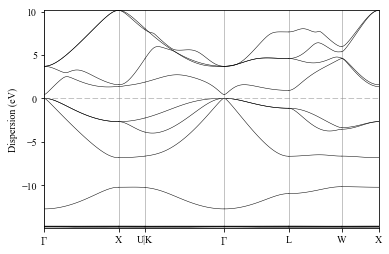

In [10]:
fermi_energy = results_GaAs['scf_parameters'].dict.fermi_energy
results_GaAs['bandstructure'].show_mpl(y_origin=fermi_energy, plot_zero_axis=True)

In [11]:
results_hBN = run(
    PwBandsWorkChain,
    codename=codename,
    structure=structure_hBN,
)

05/18/2017 07:34:30 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19681|PwBandsWorkChain|setup_protocol]: running the workchain in the "standard" protocol
05/18/2017 07:34:30 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19681|PwBandsWorkChain|run_relax]: launching PwBaseWorkChain<19692> in vc-relax mode
05/18/2017 07:51:27 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19681|PwBandsWorkChain|run_scf]: launching PwBaseWorkChain<19710> in scf mode
05/18/2017 07:53:53 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19681|PwBandsWorkChain|run_bands]: launching PwBaseWorkChain<19722> in bands mode
05/18/2017 07:56:48 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19681|PwBandsWorkChain|run_results]: workchain succesfully completed


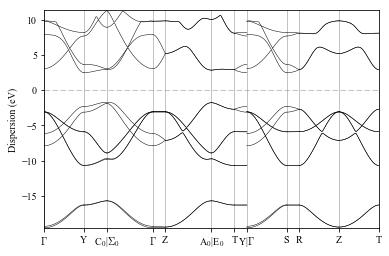

In [12]:
fermi_energy = results_hBN['scf_parameters'].dict.fermi_energy
results_hBN['bandstructure'].show_mpl(y_origin=fermi_energy, plot_zero_axis=True)

In [13]:
results_CaF2 = run(
    PwBandsWorkChain,
    codename=codename,
    structure=structure_CaF2,
)

05/18/2017 07:56:49 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19733|PwBandsWorkChain|setup_protocol]: running the workchain in the "standard" protocol
05/18/2017 07:56:50 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19733|PwBandsWorkChain|run_relax]: launching PwBaseWorkChain<19744> in vc-relax mode
05/18/2017 08:00:01 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19733|PwBandsWorkChain|run_scf]: launching PwBaseWorkChain<19762> in scf mode
05/18/2017 08:00:56 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19733|PwBandsWorkChain|run_bands]: launching PwBaseWorkChain<19774> in bands mode
05/18/2017 08:02:36 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19733|PwBandsWorkChain|run_results]: workchain succesfully completed


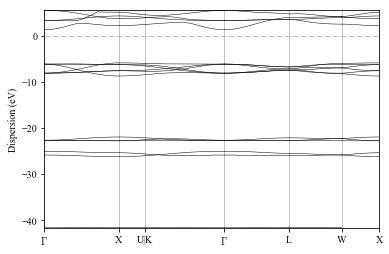

In [14]:
fermi_energy = results_CaF2['scf_parameters'].dict.fermi_energy
results_CaF2['bandstructure'].show_mpl(y_origin=fermi_energy, plot_zero_axis=True)

In [15]:
results_Cu = run(
    PwBandsWorkChain,
    codename=codename,
    structure=structure_Cu,
)

05/18/2017 08:02:37 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19785|PwBandsWorkChain|setup_protocol]: running the workchain in the "standard" protocol
05/18/2017 08:02:38 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19785|PwBandsWorkChain|run_relax]: launching PwBaseWorkChain<19796> in vc-relax mode
05/18/2017 08:09:49 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19785|PwBandsWorkChain|run_scf]: launching PwBaseWorkChain<19814> in scf mode
05/18/2017 08:10:34 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19785|PwBandsWorkChain|run_bands]: launching PwBaseWorkChain<19826> in bands mode
05/18/2017 08:11:29 PM, aiida.orm.implementation.general.calculation.work.WorkCalculation: [REPORT] [19785|PwBandsWorkChain|run_results]: workchain succesfully completed


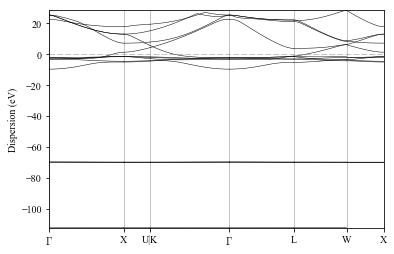

In [17]:
fermi_energy = results_Cu['scf_parameters'].dict.fermi_energy
results_Cu['bandstructure'].show_mpl(y_origin=fermi_energy, plot_zero_axis=True)